# DermaMNIST Explainability Tutorial

This notebook demonstrates explainability analysis on the **DermaMNIST dataset** - a collection of dermatoscopic images for skin lesion classification.

---

In [ ]:
# Google Colab Setup - Run this cell first!
import sys
import os

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Setting up environment...")
    
    # Install required packages
    print("\n Installing dependencies...")
    !pip install -q torch torchvision medmnist matplotlib numpy scipy scikit-learn scikit-image opencv-python tqdm
    
    # Clone the MedXAI repository to get the explainer implementations
    if not os.path.exists('MedXAI'):
        print("\n Cloning MedXAI repository...")
        !git clone -q https://github.com/Matt-Cockayne/MedXAI.git
        sys.path.insert(0, '/content/MedXAI')
    else:
        sys.path.insert(0, '/content/MedXAI')
    
    print("✓ Environment setup complete!")
else:
    print(" Running locally")
    # Add parent directory for local runs
    from pathlib import Path
    sys.path.insert(0, str(Path.cwd().parent))

print("Ready to go!")

## Overview

- **Dataset**: DermaMNIST (MedMNIST)
- **Task**: 7-class skin lesion classification
- **Classes**: Actinic Keratoses, Basal Cell Carcinoma, Benign Keratosis, Dermatofibroma, Melanoma, Melanocytic Nevi, Vascular Lesions
- **XAI Methods**: GradCAM, GradCAM++, Integrated Gradients, RISE
- **Metrics**: Deletion/Insertion AUC, Faithfulness metrics

---

## 1. Setup and Imports

First, we import all necessary libraries and configure the environment.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import from MedXAI package
from utils import (
    get_medical_dataset, load_model, 
    visualize_comparison, plot_deletion_insertion_curves
)
from explainers import GradCAM, GradCAMPlusPlus, IntegratedGradients, RISE
from metrics import DeletionInsertion, FaithfulnessMetrics

print("Imports successful")
print(f"PyTorch version: {torch.__version__}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

✓ Imports successful
PyTorch version: 2.9.1+cu128
Using device: cuda


## 2. Install and Load MedMNIST

MedMNIST is a collection of standardized medical imaging datasets. We'll use the DermaMNIST subset for skin lesion classification.

In [ ]:
# Check if medmnist is installed
try:
    import medmnist
    print("medmnist package found")
except ImportError:
    print("Installing medmnist...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "medmnist"])
    import medmnist
    print("medmnist installed")

print(f"MedMNIST version: {medmnist.__version__}")

✓ medmnist package found
MedMNIST version: 3.0.2


## 3. Load DermaMNIST Dataset

DermaMNIST contains 28x28 RGB images of skin lesions. Images are automatically resized to 224x224 for ResNet50 compatibility.

In [ ]:
# Ensure data directory exists
data_dir = Path('./data')
data_dir.mkdir(parents=True, exist_ok=True)

# Load DermaMNIST test set
print("Loading DermaMNIST dataset...")
test_dataset = get_medical_dataset(
    'dermamnist',
    root=str(data_dir),
    split='test',
    download=True
)

# Dataset info
num_classes = 7
class_names = [
    'Actinic Keratoses',
    'Basal Cell Carcinoma',
    'Benign Keratosis',
    'Dermatofibroma',
    'Melanoma',
    'Melanocytic Nevi',
    'Vascular Lesions'
]

print(f"✓ Dataset loaded: {len(test_dataset)} test images")
print(f"  Classes: {num_classes}")
print(f"  Image size: 28x28 RGB (resized to 224x224 for model)")
print(f"\nClass names:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

Loading DermaMNIST dataset...
✓ Dataset loaded: 2005 test images
  Classes: 7
  Image size: 28x28 RGB (resized to 224x224 for model)

Class names:
  0: Actinic Keratoses
  1: Basal Cell Carcinoma
  2: Benign Keratosis
  3: Dermatofibroma
  4: Melanoma
  5: Melanocytic Nevi
  6: Vascular Lesions


## 4. Load Pre-trained Model

We use a ResNet50 model adapted for 7-class classification. The model has been pre-trained (randomly initialized here, but you can load trained weights).

In [4]:
print("Loading ResNet50 model...")
model = load_model('resnet50', num_classes=num_classes, device=device)
model.eval()
print("✓ Model loaded and set to evaluation mode")
print(f"  Architecture: ResNet50")
print(f"  Output classes: {num_classes}")

Loading ResNet50 model...
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 7
✓ Model loaded and set to evaluation mode
  Architecture: ResNet50
  Output classes: 7


## 5. Initialize Explainability Methods

We initialize four different explainability methods:

- **GradCAM**: Gradient-weighted Class Activation Mapping
- **GradCAM++**: Improved pixel-wise weighting version
- **Integrated Gradients**: Path-based attribution method
- **RISE**: Randomized Input Sampling for Explanation

In [5]:
print("Initializing explainability methods...")
explainers = {
    'GradCAM': GradCAM(model, 'layer4', device),
    'GradCAM++': GradCAMPlusPlus(model, 'layer4', device),
    'Integrated Gradients': IntegratedGradients(model, device),
    'RISE': RISE(model, device, n_masks=1000)
}

print(f"✓ {len(explainers)} methods initialized:")
for name in explainers.keys():
    print(f"  - {name}")

Initializing explainability methods...
✓ 4 methods initialized:
  - GradCAM
  - GradCAM++
  - Integrated Gradients
  - RISE


## 6. Select and Visualize a Sample

Let's select a sample image from the test set and visualize both the original low-resolution (28x28) and processed (224x224) versions.

Sample #42
  True label: Melanocytic Nevi (class 5)
  Predicted: Benign Keratosis (class 2)
  Confidence: 0.185
  Correct: ✗


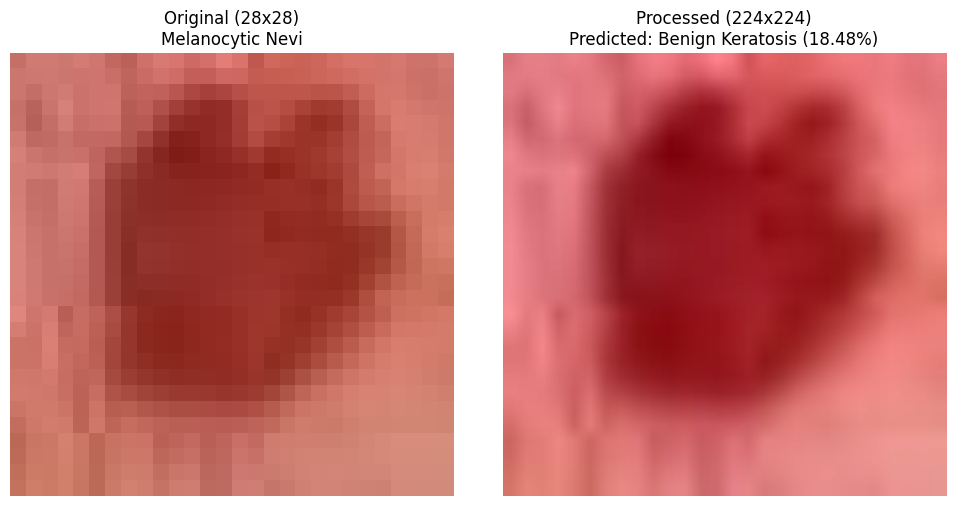

In [6]:
# Select a sample (you can change this index)
sample_idx = 42

# Get processed image and label
image, label = test_dataset[sample_idx]
label = int(label)  # Convert from numpy array to int
image_batch = image.unsqueeze(0).to(device)

# Load original image without transforms for visualization
from medmnist import INFO
info = INFO['dermamnist']
DataClass = getattr(medmnist, info['python_class'])
original_dataset = DataClass(split='test', download=False, root=str(data_dir), transform=None)
original_image = original_dataset[sample_idx][0]  # PIL Image

# Get model prediction
with torch.no_grad():
    output = model(image_batch)
    probs = torch.nn.functional.softmax(output, dim=1)
    pred_class = output.argmax(dim=1).item()
    confidence = probs[0, pred_class].item()

# Display information
print(f"Sample #{sample_idx}")
print(f"  True label: {class_names[label]} (class {label})")
print(f"  Predicted: {class_names[pred_class]} (class {pred_class})")
print(f"  Confidence: {confidence:.3f}")
print(f"  Correct: {'✓' if label == pred_class else '✗'}")

# Visualize both versions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original 28x28
axes[0].imshow(original_image)
axes[0].set_title(f'Original (28x28)\n{class_names[label]}')
axes[0].axis('off')

# Processed 224x224
img_display = image.permute(1, 2, 0).cpu().numpy()
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
axes[1].imshow(img_display)
axes[1].set_title(f'Processed (224x224)\nPredicted: {class_names[pred_class]} ({confidence:.2%})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 7. Generate Explanations

Now we generate saliency maps using all four explainability methods. Each method highlights which pixels were most important for the model's prediction.

In [7]:
print("Generating explanations...\n")
explanations = {}

for name, explainer in explainers.items():
    print(f"  Generating {name}...", end=' ')
    try:
        explanation = explainer.explain(image_batch, target_class=label)
        explanations[name] = explanation
        print(f"✓ Shape: {explanation.shape}")
    except Exception as e:
        print(f"✗ Error: {e}")

print(f"\n✓ Generated {len(explanations)} explanations")

Generating explanations...

  Generating GradCAM... ✓ Shape: torch.Size([224, 224])
  Generating GradCAM++... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating Integrated Gradients... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])
  Generating RISE... ✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations
✓ Shape: torch.Size([224, 224])

✓ Generated 4 explanations


## 8. Visualize Explanation Comparison

Let's visualize all explanations side-by-side as heatmaps overlaid on the original image.

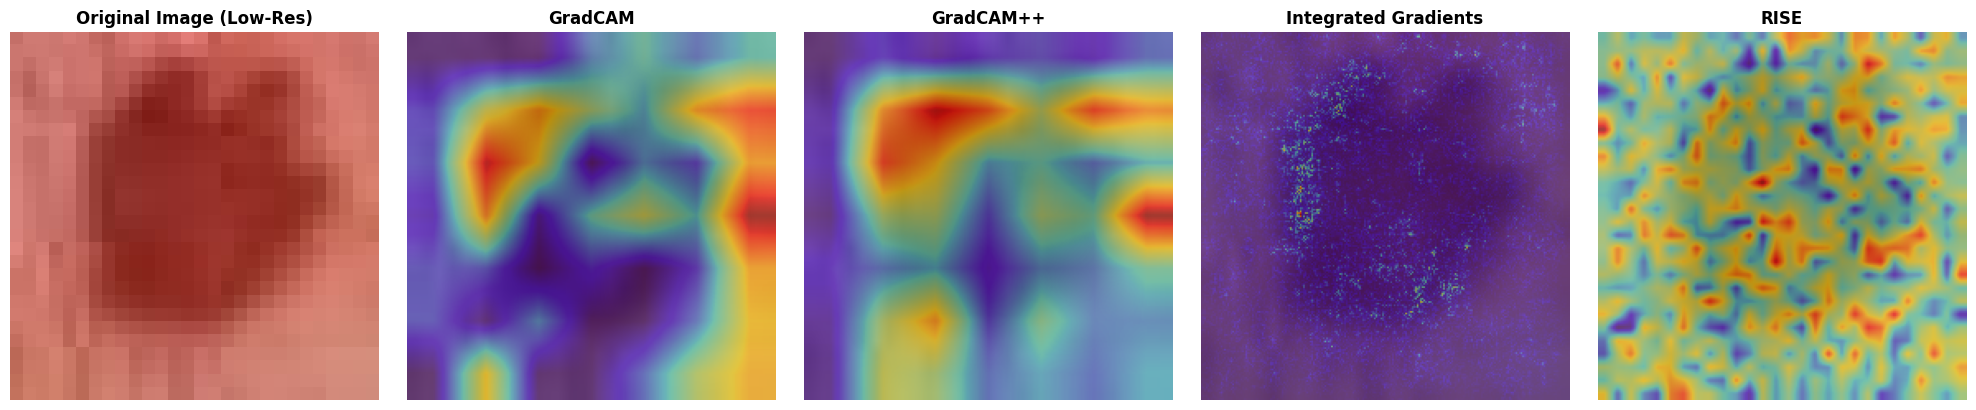


Explanation heatmaps show which regions influenced the model's prediction.
Warmer colors (red/yellow) indicate higher importance.


In [8]:
# Create comprehensive visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=None  # Set to path if you want to save
)
plt.show()

print("\nExplanation heatmaps show which regions influenced the model's prediction.")
print("Warmer colors (red/yellow) indicate higher importance.")

## 9. Quantitative Evaluation: Deletion & Insertion Metrics

We evaluate explanation quality using:

- **Deletion AUC**: Measures confidence drop when removing important pixels (lower is better)
- **Insertion AUC**: Measures confidence rise when adding important pixels (higher is better)

In [9]:
print("Computing Deletion/Insertion metrics...\n")
di_metric = DeletionInsertion(model, device, n_steps=50)
results = {}

for name, heatmap in explanations.items():
    print(f"  Evaluating {name}...", end=' ')
    try:
        result = di_metric.evaluate(image_batch, heatmap, label)
        results[name] = result
        print(f"Del: {result['deletion_auc']:.3f}, Ins: {result['insertion_auc']:.3f}")
    except Exception as e:
        print(f"Error: {e}")

print("\n✓ Evaluation complete")

Computing Deletion/Insertion metrics...

  Evaluating GradCAM... Del: 0.170, Ins: 0.171
  Evaluating GradCAM++... Del: 0.170, Ins: 0.171
  Evaluating GradCAM++... Del: 0.172, Ins: 0.171
  Evaluating Integrated Gradients... Del: 0.172, Ins: 0.171
  Evaluating Integrated Gradients... Del: 0.166, Ins: 0.169
  Evaluating RISE... Del: 0.166, Ins: 0.169
  Evaluating RISE... Del: 0.171, Ins: 0.172

✓ Evaluation complete
Del: 0.171, Ins: 0.172

✓ Evaluation complete


## 10. Plot Deletion & Insertion Curves

Visualize how the model's confidence changes as pixels are progressively deleted or inserted based on importance scores.

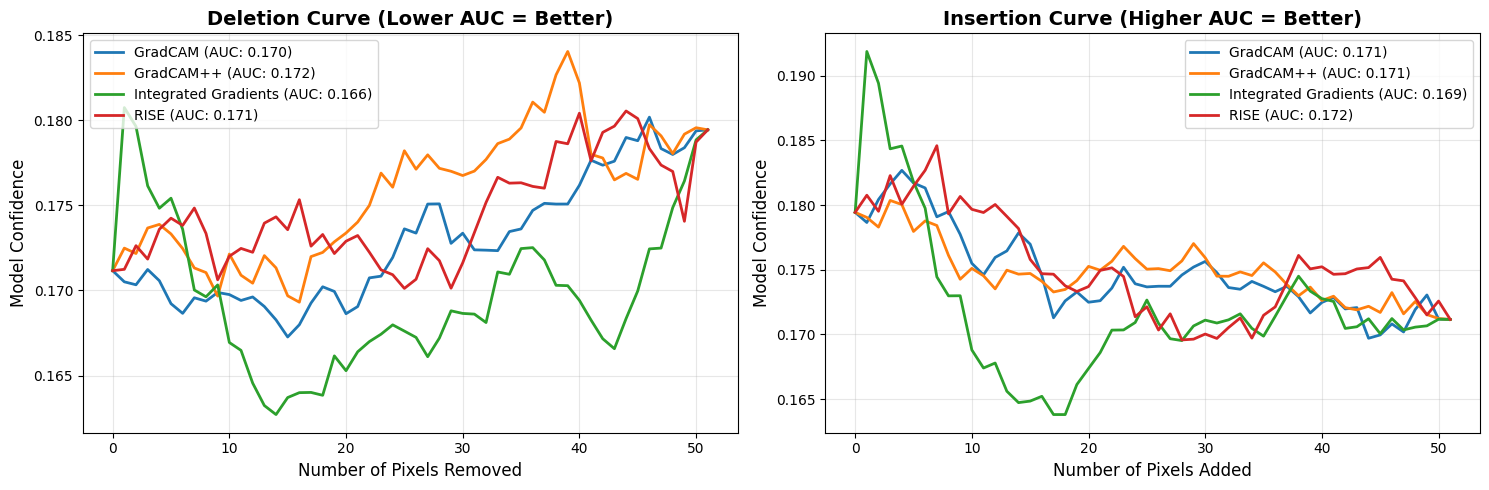


Interpretation:
  Deletion: Steeper drop = better explanation (found important pixels)
  Insertion: Faster rise = better explanation (sufficient information)


In [10]:
if results:
    fig = plot_deletion_insertion_curves(results, save_path=None)
    plt.show()
    
    print("\nInterpretation:")
    print("  Deletion: Steeper drop = better explanation (found important pixels)")
    print("  Insertion: Faster rise = better explanation (sufficient information)")

## 11. Faithfulness Metrics

Compute additional faithfulness metrics for the top-performing methods:

- **Sensitivity-n**: Correlation between attribution and output changes
- **Infidelity**: Squared difference between attribution and actual impact
- **Monotonicity**: Whether importance scores maintain order with cumulative perturbations

In [11]:
print("Computing faithfulness metrics for top methods...\n")
faith_metric = FaithfulnessMetrics(model, device)

# Evaluate top 2 methods
for name, heatmap in list(explanations.items())[:2]:
    print(f"  {name}:")
    try:
        metrics = faith_metric.evaluate_all(image_batch, heatmap, label)
        for metric_name, value in metrics.items():
            print(f"    - {metric_name}: {value:.3f}")
        print()
    except Exception as e:
        print(f"    Error: {e}\n")

Computing faithfulness metrics for top methods...

  GradCAM:
    - sensitivity_n: 0.111
    - infidelity: 182.848
    - monotonicity: 0.569

  GradCAM++:
    - sensitivity_n: 0.111
    - infidelity: 182.848
    - monotonicity: 0.569

  GradCAM++:
    - sensitivity_n: -0.015
    - infidelity: 229.546
    - monotonicity: 0.510

    - sensitivity_n: -0.015
    - infidelity: 229.546
    - monotonicity: 0.510



## 12. Results Summary

Let's summarize and rank all methods based on their performance.

In [12]:
print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)

print(f"\nSample: {class_names[label]} (True) → {class_names[pred_class]} (Predicted)\n")

print("Deletion AUC Rankings (lower is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['deletion_auc']), 1):
    print(f"  {i}. {method:25s}: {result['deletion_auc']:.4f}")

print("\nInsertion AUC Rankings (higher is better):")
for i, (method, result) in enumerate(sorted(results.items(), key=lambda x: x[1]['insertion_auc'], reverse=True), 1):
    print(f"  {i}. {method:25s}: {result['insertion_auc']:.4f}")

print("\n" + "=" * 70)

RESULTS SUMMARY

Sample: Melanocytic Nevi (True) → Benign Keratosis (Predicted)

Deletion AUC Rankings (lower is better):
  1. Integrated Gradients     : 0.1664
  2. GradCAM                  : 0.1695
  3. RISE                     : 0.1712
  4. GradCAM++                : 0.1723

Insertion AUC Rankings (higher is better):
  1. RISE                     : 0.1718
  2. GradCAM++                : 0.1715
  3. GradCAM                  : 0.1713
  4. Integrated Gradients     : 0.1686



## 13. Save Results (Optional)

Save visualizations and numerical results for future reference.

In [ ]:
# Create output directory
output_dir = Path('./results/dermamnist')
output_dir.mkdir(parents=True, exist_ok=True)

# Save original image
original_image.save(output_dir / f'sample_{sample_idx}_original.png')
print(f"✓ Saved original image")

# Save comparison visualization
fig = visualize_comparison(
    image,
    explanations,
    original_image=original_image,
    save_path=output_dir / f'sample_{sample_idx}_comparison.png'
)
plt.close(fig)
print(f"✓ Saved comparison visualization")

# Save curves
if results:
    fig = plot_deletion_insertion_curves(
        results,
        save_path=output_dir / f'sample_{sample_idx}_curves.png'
    )
    plt.close(fig)
    print(f"✓ Saved deletion/insertion curves")

print(f"\nAll results saved to: {output_dir}")

✓ Saved original image
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/dermamnist
✓ Saved comparison visualization
✓ Saved deletion/insertion curves

All results saved to: ../results/dermamnist


## Conclusion

This notebook demonstrated:

1. ✓ Loading DermaMNIST dataset from MedMNIST
2. ✓ Initializing 4 explainability methods (GradCAM, GradCAM++, Integrated Gradients, RISE)
3. ✓ Generating visual explanations (saliency maps)
4. ✓ Quantitative evaluation with Deletion/Insertion metrics
5. ✓ Faithfulness assessment
6. ✓ Comparative analysis of methods

### Key Takeaways:

- Different XAI methods highlight different regions as important
- Quantitative metrics help assess explanation quality objectively
- Both visual inspection and numerical evaluation are important
- Method performance can vary across samples

### Next Steps:

- Try different sample indices
- Experiment with other MedMNIST datasets (PneumoniaMNIST, ChestMNIST)
- Fine-tune the model on the dataset for better predictions
- Compare explanations across correct vs. incorrect predictions